# Calculate street network indicators

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd

## Basic street network measures (topological and geometric)

In [2]:
G = ox.load_graphml('./data/network_ch.graphml')
stats = ox.stats.basic_stats(G)

In [3]:
stats['circuity_avg']

1.0997328029435847

To calculate density-based stats,also pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation):

In [8]:
Gp = ox.projection.project_graph(G)
nodes_proj = ox.convert.graph_to_gdfs(Gp, edges=False)
area = nodes_proj.union_all().convex_hull.area

stats = ox.stats.basic_stats(G, area=area)
pd.Series(stats)

n                                                                            2163
m                                                                            5084
k_avg                                                                    4.700878
edge_length_total                                                   761269.448386
edge_length_avg                                                        149.738286
streets_per_node_avg                                                     2.597781
streets_per_node_counts              {0: 0, 1: 559, 2: 40, 3: 1284, 4: 272, 5: 8}
streets_per_node_proportions    {0: 0.0, 1: 0.2584373555247342, 2: 0.018492834...
intersection_count                                                           1604
street_length_total                                                 415356.654101
street_segment_count                                                         2797
street_length_avg                                                       148.50077
circuity_avg    

Streets/intersection counts and proportions are nested dicts inside the stats dict. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [9]:
# unpack dicts into individiual keys:values
stats = ox.stats.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats[f"{k}way_int_count"] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats[f"{k}way_int_prop"] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,2163.000
m,5084.000
k_avg,4.701
edge_length_total,761269.448
edge_length_avg,149.738
streets_per_node_avg,2.598
intersection_count,1604.000
street_length_total,415356.654
street_segment_count,2797.000
street_length_avg,148.501


## Betweenness centrality

In [10]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.convert.to_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(3151528887, 0.24998769285299358)

In Chapel Hill, 

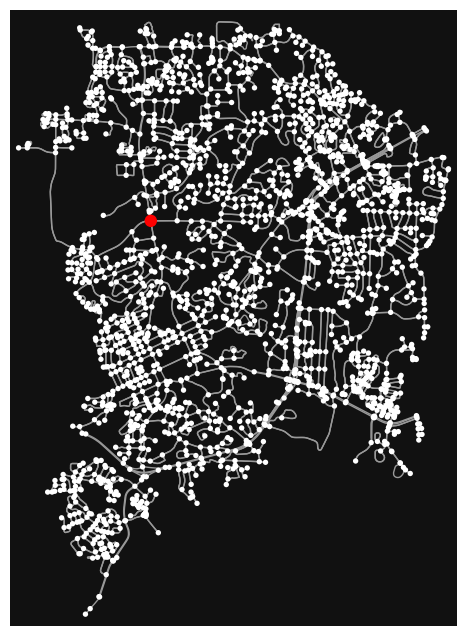

In [11]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

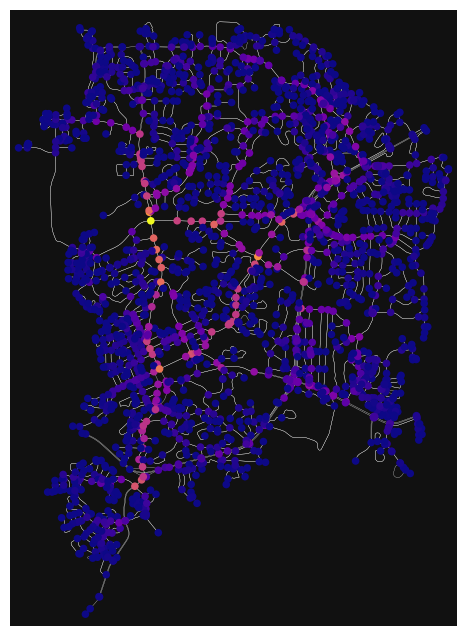

In [12]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)